In [7]:
# All in one
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from skimage.measure import perimeter
print('1/4 Imports Done')


# SAM params
CHECKPOINT_PATH='/home/rka/code/sam_try/sam_vit_b_01ec64.pth'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)
print('2/4 SAM params Initialized')

# SAM result
IMAGE_PATH = '/home/rka/code/fly_courtship/all_frames/frame_0001.png'
image= cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# SAM
sam_result = mask_generator.generate(image_rgb)
print('3/4 SAM result generated')

# Save MAT
from scipy.io import savemat
for i in range(len(sam_result)):
    arena_mask = sam_result[i]['segmentation']
    area = sam_result[i]['area']
    savemat(f"c{i+1}.mat", {'segment': arena_mask, 'area': area})
print('4/4 Saved mat files')

1/4 Imports Done
2/4 SAM params Initialized
3/4 SAM result generated
4/4 Saved mat files


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from skimage.measure import perimeter

In [2]:
# SAM params
CHECKPOINT_PATH='/home/rka/code/sam_try/sam_vit_b_01ec64.pth'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
IMAGE_PATH = '/home/rka/code/fly_courtship/all_frames/frame_0001.png'
image= cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# SAM
sam_result = mask_generator.generate(image_rgb)

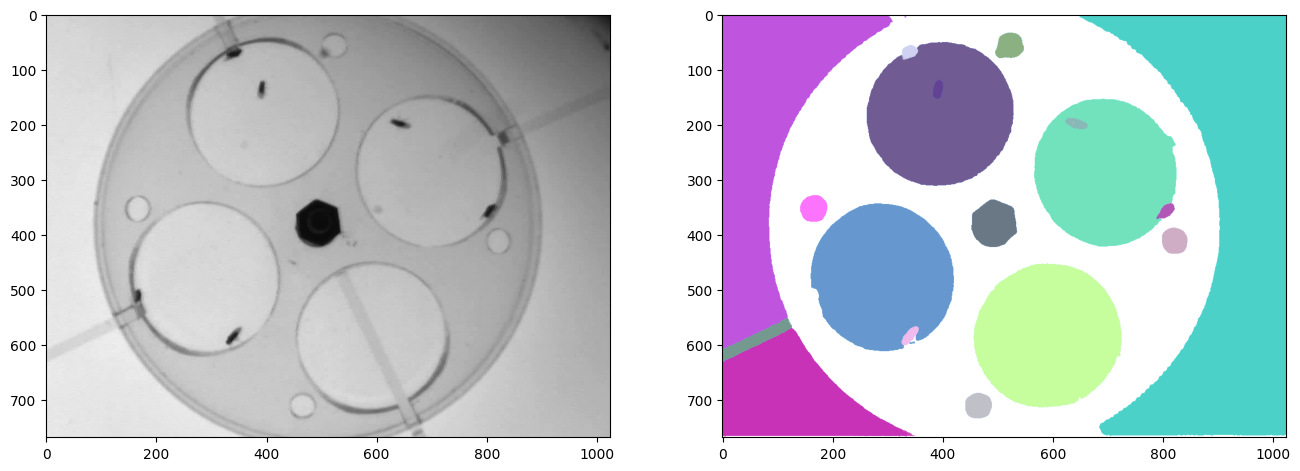

In [5]:
# for debugging
# Function that inputs the output and plots image and mask
def show_output(result_dict,axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))
            
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
show_output(sam_result, axes[1])

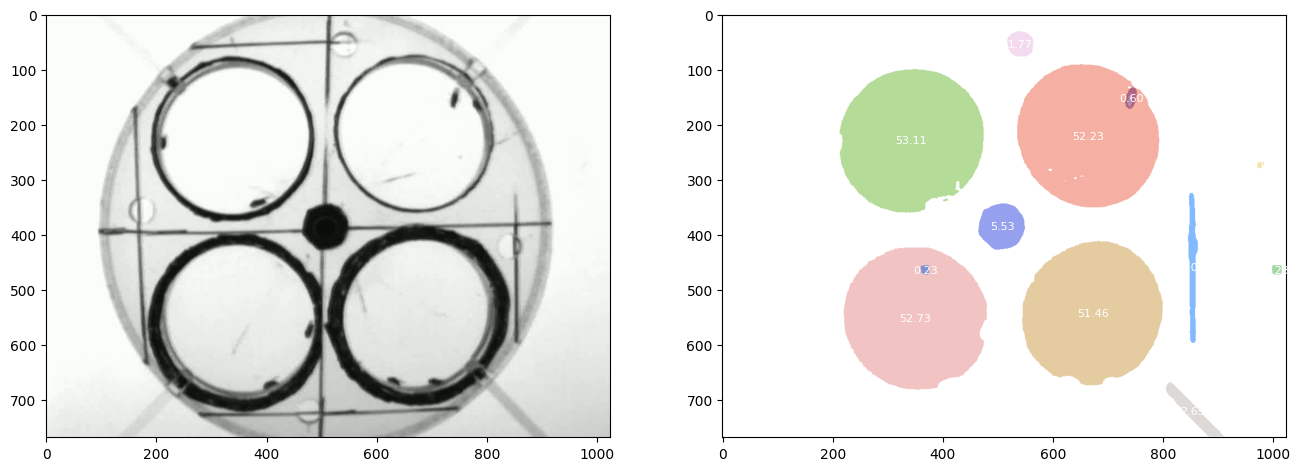

In [15]:
# Function that inputs the output and plots image and mask with area
def show_output2(result_dict, axes=None):
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)

    sorted_result = sorted(result_dict, key=(lambda x: x['area']), reverse=True)

    # Plot for each segment area
    for val in sorted_result:
        mask = val['segmentation']
        area = val['area']/1000

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        for i in range(3):
            img[:, :, i] = color_mask[i]

        ax.imshow(np.dstack((img, mask * 0.5)))

        # Find the center of the mask to place the text
        y, x = np.where(mask)
        center_x, center_y = np.mean(x), np.mean(y)

        # Add the area text on the mask
        ax.text(center_x, center_y, f'{area:.2f}', color='white', ha='center', va='center', fontsize=8)

# Example usage
_, axes = plt.subplots(1, 2, figsize=(16, 16))
# Replace 'image_rgb' with your actual RGB image
axes[0].imshow(image_rgb)
show_output2(sam_result, axes[1])


Len of copied selected indices  15


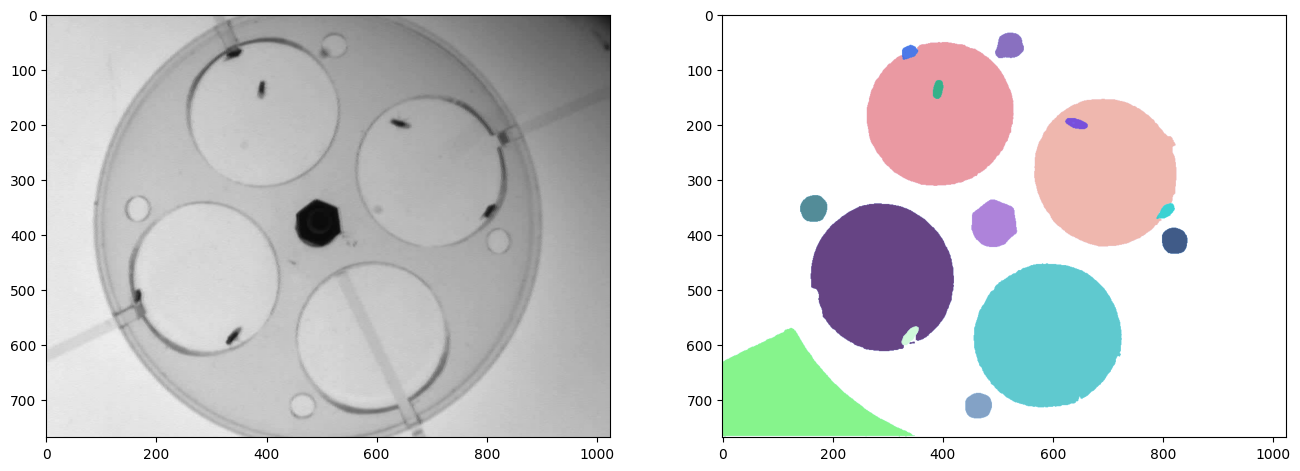

In [10]:
# Circularity and Arena btn 40k to 50k sq pixels 
def estimated_circularity(mask):
    area = np.sum(mask)
    perim = perimeter(mask)
    circularity = (4 * np.pi * area) / (perim ** 2)
    return circularity

selected_indices = []

# Iterate over the segments
for idx, segment in enumerate(sam_result):
    mask = segment['segmentation']
    area = segment['area']
    area_scaled = area / 1000  # Scale the area as per your requirement

    # Check if the area is between 40 and 50 and circularity is >= 0.5
    if estimated_circularity(mask) >= 0.5:
        selected_indices.append(idx)

# Remove overlapping regions
def calculate_overlap(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    if np.sum(union) == 0:
        return 0
    return np.sum(intersection) / np.sum(union)

len_selected_indices = len(selected_indices)
copied_selected_indices = selected_indices.copy()

for i in range(len_selected_indices-1):
    for j in range(i+1, len_selected_indices):
        mask1 = sam_result[selected_indices[i]]['segmentation']
        mask2 = sam_result[selected_indices[j]]['segmentation']
        
        overlap_percent = 100*calculate_overlap(mask1, mask2)
        if overlap_percent > 50:
            area_mask1 = sam_result[selected_indices[i]]['area']
            area_mask2 = sam_result[selected_indices[j]]['area']
            
            
            if area_mask1 > area_mask2:
                removal_index = j
            else:
                removal_index = i
            
            copied_selected_indices.pop(selected_indices[removal_index])
            
print('Len of copied selected indices ', len(copied_selected_indices))

sam_selected_4 = [sam_result[i] for i in copied_selected_indices]

# Example usage
_, axes = plt.subplots(1, 2, figsize=(16, 16))
# Replace 'image_rgb' with your actual RGB image
axes[0].imshow(image_rgb)
show_output(sam_selected_4, axes[1])

    

In [5]:
from scipy.io import savemat


for i in range(4):
    arena_mask = sam_selected_4[i]['segmentation']
    savemat(f"c{i+1}.mat", {'mat': arena_mask})

NameError: name 'sam_selected_4' is not defined

In [6]:
from scipy.io import savemat


for i in range(len(sam_result)):
    arena_mask = sam_result[i]['segmentation']
    area = sam_result[i]['area']
    savemat(f"c{i+1}.mat", {'segment': arena_mask, 'area': area})

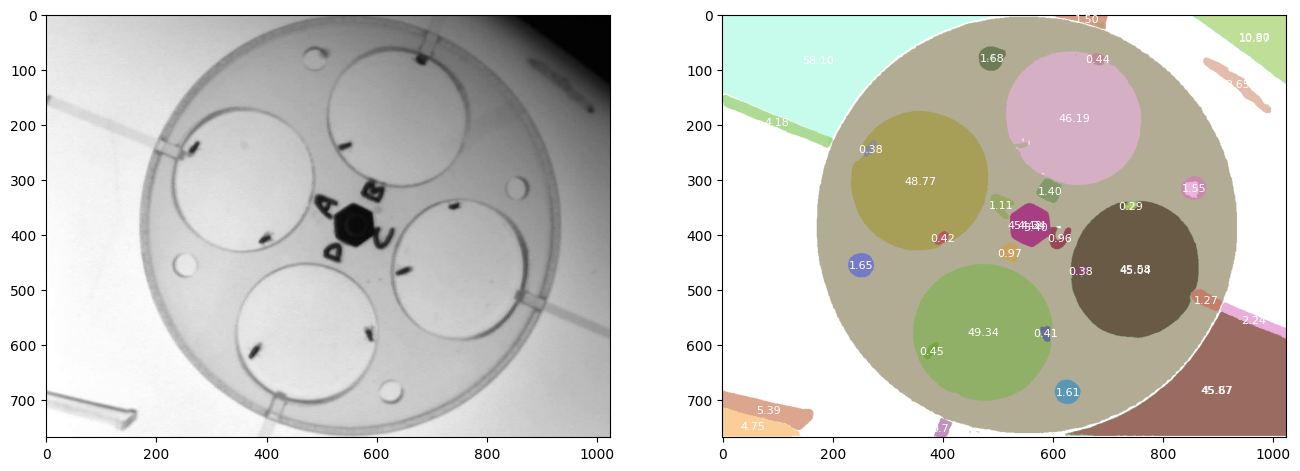

In [8]:
# ## Debugging with area
# # Function that inputs the output and plots image and mask with area
# def show_output2(result_dict, axes=None):
#     if axes:
#         ax = axes
#     else:
#         ax = plt.gca()
#         ax.set_autoscale_on(False)

#     sorted_result = sorted(result_dict, key=(lambda x: x['area']), reverse=True)

#     # Plot for each segment area
#     for val in sorted_result:
#         mask = val['segmentation']
#         area = val['area']/1000

#         # Generate a random color for the mask
#         color_mask = np.random.random((1, 3)).tolist()[0]
#         img = np.ones((mask.shape[0], mask.shape[1], 3))
#         for i in range(3):
#             img[:, :, i] = color_mask[i]

#         ax.imshow(np.dstack((img, mask * 0.5)))

#         # Find the center of the mask to place the text
#         y, x = np.where(mask)
#         center_x, center_y = np.mean(x), np.mean(y)

#         # Add the area text on the mask
#         ax.text(center_x, center_y, f'{area:.2f}', color='white', ha='center', va='center', fontsize=8)

# # Example usage
# _, axes = plt.subplots(1, 2, figsize=(16, 16))
# # Replace 'image_rgb' with your actual RGB image
# axes[0].imshow(image_rgb)
# show_output2(sam_result, axes[1])
